In [72]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.cluster import hierarchy
import warnings
warnings.simplefilter('ignore')

#### Модифицировать реализацию KNN из методички так, чтобы больший вес получали наиболее близко расположенные объекты

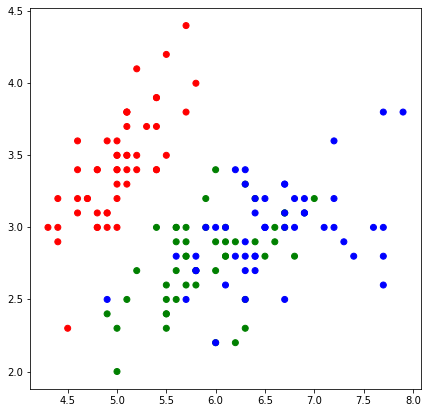

In [78]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [79]:
def e_metrics(x1, x2):
     return np.sqrt(np.sum((x2-x1)**2))
      

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [80]:
def knn(x_train, y_train, x_test, k):
    
    answers_dist_weight = [] # ответы при расчете весов в зависимости от расстояния по формуле w(i) = 1/(d+a)^b
    answers_num_weight = [] # ответы при расчете весов в зависимости от номера по формуле w(i) = (k+1-i) /k
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            distance = e_metrics(x, x_train[i])
            test_distances.append((distance, y_train[i]))
        
        classes_for_dist = {class_item: 0 for class_item in set(y_train)}
        classes_for_num = classes_for_dist.copy()

        a = 0.01
        b = 2
        for num, d in enumerate(sorted(test_distances)[0:k]):
            classes_for_dist[d[1]] += 1/(d[0]+a)**b
            classes_for_num[d[1]] += (k+1-num)/k
  
        # Записываем в список ответов наиболее часто встречающийся класс
        answers_dist_weight.append(sorted(classes_for_dist, key=classes_for_dist.get)[-1])
        answers_num_weight.append(sorted(classes_for_num, key=classes_for_num.get)[-1])
        
    return answers_dist_weight, answers_num_weight

In [81]:
k = 10

y_pred_dist, y_pred_num = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма c весами,зависящими от расстояния, при k = {k}: {accuracy(y_pred_dist, y_test):.3f}')
print(f'Точность алгоритма c весами,зависящими от номера, при k = {k}: {accuracy(y_pred_num, y_test):.3f}')

Точность алгоритма c весами,зависящими от расстояния, при k = 10: 0.833
Точность алгоритма c весами,зависящими от номера, при k = 10: 0.867


#### Реализовать иерархическую кластеризацию с любой из межкластерных метрик, кроме рассмотренной на вебинаре(Average Linkage Distance). 

Использована метрика Average Centroid Linkage Distance

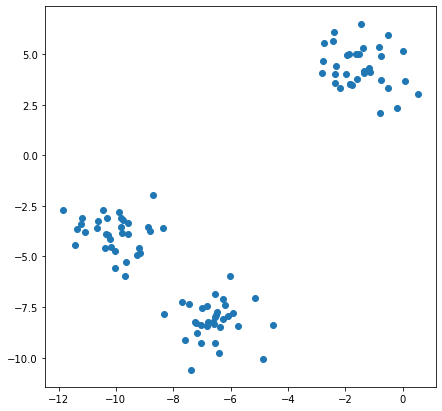

In [82]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [83]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
                
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [85]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b', 'm', 'y' ]
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

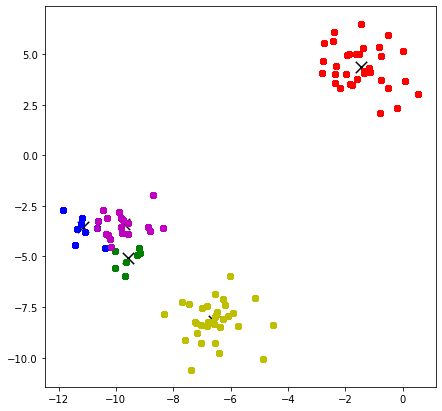

In [86]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 5

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [87]:
# сравнение среднего расстояния внутри кластера от элементов до центра и межкластерного расстояния ACLD
centers = [np.sum(clusters[i])/len(clusters[i]) for i in range(k)]

intracluster={}
for k, v in clusters.items():
    intracluster[k]=sum(e_metrics(x, centers[k]) for x in v)/len(v)

for k1, v1 in clusters.items():
    for k2, v2 in clusters.items():
        if k1==k2:
            continue
        interclass = (np.sum(e_metrics(x, centers[k2]) for x in v1) + np.sum(e_metrics(y, centers[k1]) for y in v2))/(len(v1)+len(v2))

        print(k1, k2, interclass / intracluster[k1])
    print('='*20)
        

0 1 4.581618494355809
0 2 4.642803050302758
0 3 4.007400307133172
0 4 4.059651355303558
1 0 1.9702691455231907
1 2 1.0372203049486122
1 3 1.0183856153083968
1 4 0.9691693468238612
2 0 1.8531173565008956
2 1 0.962691283421376
2 3 0.98181409228617
2 4 0.9154542497850172
3 0 1.8207222864703267
3 1 1.0759364095289845
3 2 1.1176030538512918
3 4 0.9351847805782473
4 0 1.8047546459532957
4 1 1.0018955952511388
4 2 1.019631897543748
4 3 0.915052222198705


In [88]:
#иерархическая кластеризация с Average Centroid Linkage Distance
def dist_matrix(clusters):
    matrix=np.zeros((len(clusters), len(clusters)))
    centers = [np.sum(clusters[i])/len(clusters[i]) for i in range(len(clusters))]
    for k1, v1 in clusters.items():
        for k2, v2 in clusters.items():
            if k1==k2:
                continue
            matrix[[k1, k2], [k2, k1]]=(np.sum(e_metrics(x, centers[k2]) for x in v1) + np.sum(e_metrics(y, centers[k1]) for y in v2))/(len(v1)+len(v2)) 
    return matrix

def indexes_to_combine(dist_matrix):
    min_el=dist_matrix[np.triu_indices(dist_matrix.shape[0], 1)].min()
    return np.argwhere(dist_matrix==min_el)[0], min_el

def exclude_clusters(i, j, dist_matrix):
    mask=np.ones(dist_matrix.shape[0], dtype=bool)
    mask[i]=False
    mask[j]=False
    return dist_matrix[mask, :][:, mask]

def merge_clusters(i, j, clusters):
    new_cluster=clusters[i]+clusters[j]
    return new_cluster, [c for k, c in enumerate(clusters) if not k in [i, j]]

def include_cluster(dist_mat, old_clusters, new_cluster):
    centers = [np.sum(old_clusters[i])/len(old_clusters[i]) for i in range(len(old_clusters))]
    centers.append([np.sum(new_cluster) / len(new_cluster)])
    new_col=[]
    for i in range(len(centers)-1):
        new_col.append((np.sum(e_metrics(x, centers[i]) for x in new_cluster) + np.sum(e_metrics(y, centers[-1]) for y in old_clusters[i]))/(len(new_cluster)+len(old_clusters[i])))
    new_col = np.array(new_col)[:, np.newaxis]
    dist_mat=np.concatenate([dist_mat, new_col], axis=1)
    new_row=np.concatenate([new_col.flatten(), [0]])[np.newaxis, :]
    dist_mat=np.concatenate([dist_mat, new_row], axis=0)
    return dist_mat

def hierarchy_clustering(clusters):
    cluster_keys=list(clusters.keys())
    cluster_list=[clusters[k] for k in cluster_keys]
    #cluster_list=cluster_list[:]
    dist_mat=dist_matrix(clusters)
    cluster_numbers=list(range(len(cluster_list)))
    z=[]
    new_num=len(cluster_list)
    while len(cluster_list)>1:
        [i, j], min_val=indexes_to_combine(dist_mat)
        dist_mat=exclude_clusters(i, j, dist_mat)
        new_cluster, old_clusters=merge_clusters(i, j, cluster_list)
        dist_mat=include_cluster(dist_mat, old_clusters, new_cluster)
        z.append([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
        print([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
        cluster_list=old_clusters+[new_cluster]
        cluster_numbers=[n for k, n in enumerate(cluster_numbers) if not k in [i, j]]+[new_num]
        new_num+=1
    return z

[3, 4, 9.631901380971948, 490]
[1, 5, 10.936065221698929, 579]
[2, 6, 11.092372130194809, 660]
[0, 7, 17.332715360650365, 1000]


{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75]],
 'dcoord': [[0.0, 9.631901380971948, 9.631901380971948, 0.0],
  [0.0, 10.936065221698929, 10.936065221698929, 9.631901380971948],
  [0.0, 11.092372130194809, 11.092372130194809, 10.936065221698929],
  [0.0, 17.332715360650365, 17.332715360650365, 11.092372130194809]],
 'ivl': ['r', 'b', 'g', 'm', 'y'],
 'leaves': [0, 2, 1, 3, 4],
 'color_list': ['C1', 'C1', 'C1', 'C0']}

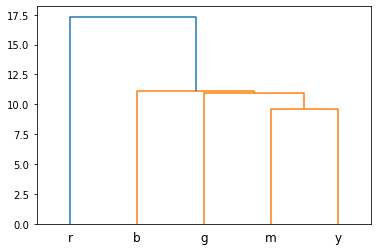

In [89]:
Z=hierarchy_clustering(clusters)
hierarchy.dendrogram(Z, labels= ['r', 'g', 'b', 'm', 'y'])